# 基本ライブラリのインポート

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import numpy as np
import sys
from tqdm import tqdm
import gym
import matplotlib.pyplot as plt
from PIL import Image
from baselines.common import atari_wrappers
from collections import namedtuple
import random

# スパルタンXの環境、コマンド

In [3]:
#環境設定
env=gym.make('KungFuMasterNoFrameskip-v0')

# ランダムでのゲーム試行

In [19]:
obs=env.reset()
video=[]
for t in range(1000):
    img=env.render(mode='human')
    action=env.action_space.sample()
    obs,re,_,_=env.step(action)
    
env.close()

# 画面の保存

In [5]:
obs=env.reset()
re_list=[]
for t in range(1):
    img=env.render(mode='rgb_array')
    action=env.action_space.sample()
    obs,re,_,_=env.step(action)
    
env.close()

#ゲーム画面をpillow形式に変換後保存
img=Image.fromarray(img)

img.save('kung.jpeg')

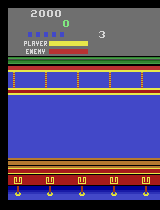

In [6]:
#ゲーム画面
img

# 使用する画面をギリギリまで削る(計算量の削減）

# 切り出す領域を引数box=(left, upper, right, lower)で指定する。

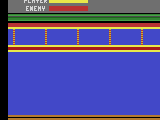

In [7]:
img.crop((0,43,160,163))

In [8]:
#上記画面のサイズ
(img.crop((0,43,160,163))).size

(160, 120)

# ライフ部分を特定する

In [9]:
img.crop((49,43,88,44))

# ライフ部分の画像値を解析する

In [10]:
np.array(img.crop((49,43,88,44)))

array([[[232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74],
        [232, 232,  74]]], dtype=uint8)

上記により、39ドットが体力であることが分かる。この[232, 232,  74]と同じの形状のtrue数にて体力を計算できる

# ダメージを設定し、損失として報酬関係に使用する

[232,232,74]と一致したものがLIFEとし、一致(True)しなかった個数はダメージとする。これでダメージ表現ができる。

In [11]:
life=39
damage_bar=img.crop((49,43,88,44))
damage=life-((np.count_nonzero(np.array(damage_bar)==[232,232,74])))

# ゲーム変数の確認

In [12]:
#stateについて
print(env.observation_space)

Box(210, 160, 3)


heightが210、widthが160、channel(rgb)が3のimageデータがstateとなっている。

In [13]:
#actionについて
print(env.action_space)
print(env.unwrapped.get_action_meanings())

Discrete(14)
['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


actionは14個のボタン、上記が対応する動作となっている。

# gameの報酬などのルールについて

上記から敵を倒すと報酬が入っている。倒す敵によってスコアは変わる。  
100～200となっている。特に非クリア時の損失設定はない。  
自機は4機

# ニューラルネットの作成方針

# ニューラルネット定数管理

In [14]:
#Box(210, 160, 3)がstateだがpytorchは(ch,h,w)の順
#のちにグレースケール、tensor化、chは先読みstep数とし、4なら躍度まで考慮に入れられるので4とする,これがstepかフレームかどうかは少し疑問、
state_shape=(4,60,80)
#actionの数と元
num_action=14
action_shape=1

#ミニバッチサイズ
batch_size=128

#時間割引率
interest_rate=0.99
ir=interest_rate #短縮

#何手先まで考えるか
num_adv_step=3

#状態を何step保持して使用するか(これがフレームかどうかは少し疑問)
num_stack_frame=4

#経験の保存数
capacity=25000
num_episode=1000
max_frame=50000

#畳み込みパラメータ
in_ch=4
out_ch=4
fc_out_ch=128
dropout_rate=0.5

#勾配法の学習率
lr=5e-5

#GPU使用
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#畳み込み効率化
torch.backends.cudnn.backends=True

# ランダムシード

In [15]:
torch.manual_seed(6)
np.random.seed(6)

# 環境変数の定義 

In [16]:
Transition=namedtuple('tr',('state','action','reward','next_state'))

# DQNの定義

In [7]:
class Dqn(nn.Module):
    def __init__(self):
        super().__init__() 
        layer=[]
        for i in range(2):
            layer.append(nn.Conv2d(in_ch,out_ch,kernel_size=3,padding=1))
            layer.append(nn.BatchNorm2d(out_ch))
            layer.append(nn.ReLU(inplace=True))
        self.seq=nn.Sequential(*layer)
        a,b,c=state_shape
        self.fc1=nn.Linear(a*b*c,fc_out_ch)
        self.q_value=nn.Linear(fc_out_ch,num_action)
        self.dropout=nn.Dropout(dropout_rate)
    
    def forward(self,state):
        
        x=self.seq(state)
        x=x.reshape(x.shape[0],-1)
        
        x=self.fc1(x)
        x=self.dropout(x)
        x=torch.relu(x)
        q_values=self.q_value(x)
        
        
        return q_values  

# メモリクラスの定義

In [8]:
class Memory:
    def __init__(self,capacity):
        self.capacity=capacity
        self.memory=[]
        self.index=0
        
    def save(self,state,action,reward,next_state):
        if len(self.memory)<self.capacity:
            self.memory.append(None)
        self.memory[self.index]=Transition(state,action,
                                          reward,next_state)
        self.index=(self.index+1)%self.capacity
        
    def sample(self,batch_size):
        
        return random.sample(self.memory,batch_size)
    
    def __len__(self):
        return len(self.memory)
    

# Brainクラスの定義

In [9]:
class Brain:
    def __init__(self):
        self.memory=Memory(capacity)
        self.main_dqn=Dqn()
        self.target_dqn=Dqn()
        self.main_dqn.to(device)
        self.target_dqn.to(device)
        self.opt=optim.Adam(self.main_dqn.parameters(),lr=lr)
        
        
    def train(self):
        if len(self.memory)<batch_size:
            return
        
        self.batch,self.state_batch,self.action_batch,self.reward_batch,self.next_batch=self.make_batch()
        
        self.target_value=self.get_target_q()
        self.train_main_dqn()
        
    def get_target_q(self):
        self.main_dqn.eval()
        self.target_dqn.eval()
        #Q(s,a)
        self.q_state_action_value=self.main_dqn(self.state_batch).gather(1,self.action_batch)
        a_m=self.main_dqn(self.next_batch).detach().max(axis=1)[1]
        a_m=a_m.reshape(-1,1)
        
        next_q_state_action_value=self.target_dqn(self.next_batch).gather(1,a_m).detach().squeeze()
        
        #
        target_value=self.reward_batch+ir*next_q_state_action_value
        
        return target_value
    
    def train_main_dqn(self):
        self.main_dqn.train()
        
        loss=F.smooth_l1_loss(self.q_state_action_value,self.target_value.unsqueeze(1))
        
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
    
    def train_target_dqn(self):
        self.target_dqn.load_state_dict(self.main_dqn.state_dict())
    
    def make_batch(self):
        exp_transition=self.memory.sample(batch_size)
        batch=Transition(*zip(*exp_transition))
        state_batch=torch.cat(batch.state)
        action_batch=torch.cat(batch.action)
        reward_batch=torch.cat(batch.reward)
        next_batch=torch.cat(batch.next_state)
        
        return batch,state_batch,action_batch,reward_batch,next_batch
        
    
    
    
    def get_action(self,state,episode):
        eps=(1/(episode*0.1+1))
        
        if eps<=np.random.uniform(0,1):
            self.main_dqn.eval()
            with torch.no_grad():
                action=self.main_dqn(state).max(axis=1)[1]
                action.to(device)
                
        else:
            action_list=list(range(14))
                        #['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']
            action_prob=[0.0765,0.0055,0.0065,0.1465,0.0765,0.0765,0.0765,0.0765,0.0765,0.0765,0.0265,0.1265,0.0265,0.1265]
                        
            action=np.random.choice(action_list,p=action_prob)
                        
            action=torch.LongTensor([action]).to(device)
        return action
                
        
        
        
    
        
        

# Enviromentクラスの作成

In [10]:
class Env:
    def run(self):
        brain=Brain()
        life=39
        state=torch.zeros(1,4,60,80)
        next_state=torch.zeros(1,4,60,80)
        
        for episode in tqdm(range(num_episode),position=0):
             
            #obs=(210, 160, 3),(1,80,60)へ変更、grayscaleへ変換
            obs=env.reset()
            obs=Image.fromarray(obs)
            #obsの形状は(120,160)
            obs=obs.crop((0,43,160,163))
            obs=obs.convert('L')
            #resize(60,80)
            obs=obs.resize((80,60),Image.BILINEAR)
            for i in range(4):
                state[0,i]=transforms.functional.to_tensor(obs)
            total_reward=0
            
            for step in range(max_frame):
                reward=0
                env.render()
                
                #1フレームあたり4連続で同じボタンを押す。1動作４フレーム以上かかるために途中に違うボタンを学習させないため
                for i in range(4):
                    action=brain.get_action(state.to(device),episode)
                    next_obs_,reward_,done,_=env.step(action.item())
                    #rewardを1、2点くらいに変更
                    reward+=reward_
                    
                    #obs=(210, 160, 3),(1,80,60)へ変更、grayscaleへ変換
                    next_img=Image.fromarray(next_obs_)
                    #obsの形状は(120,160)
                    next_img1=next_img.crop((0,43,160,163))
                    next_obs=next_img1.convert('L')
                    next_obs=next_obs.resize((80,60),Image.BILINEAR)
                    next_obs=transforms.functional.to_tensor(next_obs)
                    next_state[0,i]=next_obs
                    
                     #左に進んだら報酬
                    if action==3:
                        reward+=0.3
                    total_reward+=reward


                #ダメージを受けていれば報酬を-1とする。
                damage_bar=next_img.crop((49,43,88,44))
                
                damage=life-((np.count_nonzero(np.array(damage_bar)==[232,232,74])/3))
                life=life-damage
                if life<=0:
                    life=39
                if damage==39:
                    damage=0
                
                
                
                
                    
                reward+=-damage
                    


                   
                    


                if done:
                    print(f'{episode}episode_reward:{total_reward}')
                    env.close()
                    break

                    
                else:
                    reward=torch.Tensor([reward])
                    brain.memory.save(state.to(device),action.unsqueeze_(0),reward.to(device),next_state.to(device))
                    brain.train()
                    state=next_state
                    next_state=torch.zeros(1,4,60,80)
            if (episode+1)%2==0:
                brain.train_target_dqn()
            if (episode+1)%20==0:
                torch.save(brain.main_dqn.state_dict(),f'weight_{episode}.pth')
    

In [ ]:
kunfu=Env()
kunfu.run()

  0%|          | 1/1000 [00:36<10:00:12, 36.05s/it]

0episode_reward:12496.299999999788


  0%|          | 2/1000 [01:11<9:56:23, 35.86s/it] 

1episode_reward:9413.699999999923


  0%|          | 3/1000 [01:47<9:55:09, 35.82s/it]

2episode_reward:16558.599999999507


  0%|          | 4/1000 [02:14<9:13:07, 33.32s/it]

3episode_reward:8373.400000000194


  0%|          | 5/1000 [02:41<8:39:10, 31.31s/it]

4episode_reward:6754.700000000322


  1%|          | 6/1000 [03:11<8:35:19, 31.11s/it]

5episode_reward:6307.500000000227


  1%|          | 7/1000 [03:44<8:41:56, 31.54s/it]

6episode_reward:8459.60000000015


  1%|          | 8/1000 [04:12<8:26:01, 30.61s/it]

7episode_reward:8561.80000000026


  1%|          | 9/1000 [04:46<8:42:16, 31.62s/it]

8episode_reward:10303.7


  1%|          | 10/1000 [05:12<8:14:25, 29.96s/it]

9episode_reward:6131.700000000121


  1%|          | 11/1000 [05:45<8:24:07, 30.58s/it]

10episode_reward:8650.100000000264


  1%|          | 12/1000 [06:14<8:16:03, 30.12s/it]

11episode_reward:7723.500000000302


  1%|▏         | 13/1000 [06:51<8:50:58, 32.28s/it]

12episode_reward:12248.199999999779


  1%|▏         | 14/1000 [07:18<8:23:59, 30.67s/it]

13episode_reward:4839.800000000103


  2%|▏         | 15/1000 [07:49<8:24:14, 30.72s/it]

14episode_reward:6556.300000000188


  2%|▏         | 16/1000 [08:16<8:08:46, 29.80s/it]

15episode_reward:5379.900000000131


  2%|▏         | 17/1000 [08:44<7:57:32, 29.15s/it]

16episode_reward:4862.600000000106


  2%|▏         | 18/1000 [09:17<8:14:32, 30.22s/it]

17episode_reward:5796.600000000224


  2%|▏         | 19/1000 [09:42<7:49:57, 28.74s/it]

18episode_reward:4352.500000000121


  2%|▏         | 20/1000 [10:15<8:10:04, 30.00s/it]

19episode_reward:8110.700000000188


  2%|▏         | 21/1000 [10:40<7:46:51, 28.61s/it]

20episode_reward:6772.500000000135


  2%|▏         | 22/1000 [11:07<7:35:50, 27.97s/it]

21episode_reward:9825.500000000035


  2%|▏         | 23/1000 [11:37<7:45:29, 28.59s/it]

22episode_reward:6370.700000000087


  2%|▏         | 24/1000 [12:12<8:16:41, 30.53s/it]

23episode_reward:8105.600000000206


  2%|▎         | 25/1000 [12:37<7:52:25, 29.07s/it]

24episode_reward:4621.100000000075


  3%|▎         | 26/1000 [13:13<8:23:15, 31.00s/it]

25episode_reward:12015.699999999772


  3%|▎         | 27/1000 [13:47<8:38:25, 31.97s/it]

26episode_reward:10007.199999999963


  3%|▎         | 28/1000 [14:17<8:25:34, 31.21s/it]

27episode_reward:9355.600000000008


  3%|▎         | 29/1000 [14:40<7:48:55, 28.98s/it]

28episode_reward:5708.90000000009


  3%|▎         | 30/1000 [15:06<7:34:03, 28.09s/it]

29episode_reward:5702.300000000131


  3%|▎         | 31/1000 [15:43<8:15:51, 30.70s/it]

30episode_reward:9867.299999999988


  3%|▎         | 32/1000 [16:17<8:31:28, 31.70s/it]

31episode_reward:9353.099999999984


  3%|▎         | 33/1000 [16:51<8:40:26, 32.29s/it]

32episode_reward:15087.799999999877


  3%|▎         | 34/1000 [17:28<9:04:09, 33.80s/it]

33episode_reward:10128.40000000001


  4%|▎         | 35/1000 [17:56<8:35:48, 32.07s/it]

34episode_reward:8500.600000000039


  4%|▎         | 36/1000 [18:27<8:27:03, 31.56s/it]

35episode_reward:6435.70000000007


  4%|▎         | 37/1000 [19:05<8:57:33, 33.49s/it]

36episode_reward:12504.40000000001


  4%|▍         | 38/1000 [19:30<8:17:45, 31.05s/it]

37episode_reward:5910.700000000072


  4%|▍         | 39/1000 [20:17<9:35:08, 35.91s/it]

38episode_reward:14157.799999999874


  4%|▍         | 40/1000 [20:48<9:11:46, 34.49s/it]

39episode_reward:9329.10000000006


  4%|▍         | 41/1000 [21:26<9:27:18, 35.49s/it]

40episode_reward:11757.199999999928


  4%|▍         | 42/1000 [21:59<9:15:52, 34.81s/it]

41episode_reward:8955.900000000089


  4%|▍         | 43/1000 [22:40<9:41:00, 36.43s/it]

42episode_reward:16654.6999999998


  4%|▍         | 44/1000 [23:12<9:23:05, 35.34s/it]

43episode_reward:7545.800000000071


  4%|▍         | 45/1000 [23:54<9:54:19, 37.34s/it]

44episode_reward:14385.699999999779


  5%|▍         | 46/1000 [24:28<9:35:28, 36.19s/it]

45episode_reward:12008.799999999907


  5%|▍         | 47/1000 [25:13<10:14:47, 38.71s/it]

46episode_reward:17270.7999999999


  5%|▍         | 48/1000 [25:52<10:17:42, 38.93s/it]

47episode_reward:11497.799999999894


  5%|▍         | 49/1000 [26:23<9:41:38, 36.70s/it] 

48episode_reward:7750.300000000104


  5%|▌         | 50/1000 [27:05<10:04:15, 38.16s/it]

49episode_reward:14578.599999999753


  5%|▌         | 51/1000 [27:31<9:06:31, 34.55s/it] 

50episode_reward:8322.200000000046


  5%|▌         | 52/1000 [28:11<9:29:53, 36.07s/it]

51episode_reward:11137.50000000004


  5%|▌         | 53/1000 [28:44<9:16:01, 35.23s/it]

52episode_reward:8080.000000000077


  5%|▌         | 54/1000 [29:15<8:56:54, 34.05s/it]

53episode_reward:7596.50000000008


  6%|▌         | 55/1000 [29:48<8:50:01, 33.65s/it]

54episode_reward:8246.700000000046


  6%|▌         | 56/1000 [30:14<8:14:31, 31.43s/it]

55episode_reward:5934.700000000059


  6%|▌         | 57/1000 [30:42<7:57:30, 30.38s/it]

56episode_reward:5527.900000000087


  6%|▌         | 58/1000 [31:08<7:33:46, 28.90s/it]

57episode_reward:5352.000000000046


  6%|▌         | 59/1000 [31:41<7:52:44, 30.14s/it]

58episode_reward:14696.099999999835


  6%|▌         | 60/1000 [32:08<7:38:02, 29.24s/it]

59episode_reward:9004.399999999994


  6%|▌         | 61/1000 [32:40<7:49:21, 29.99s/it]

60episode_reward:8170.900000000094


  6%|▌         | 62/1000 [33:18<8:26:13, 32.38s/it]

61episode_reward:11855.099999999919


  6%|▋         | 63/1000 [33:54<8:43:13, 33.50s/it]

62episode_reward:10233.700000000006


  6%|▋         | 64/1000 [34:27<8:39:19, 33.29s/it]

63episode_reward:9377.200000000053


  6%|▋         | 65/1000 [35:02<8:48:14, 33.90s/it]

64episode_reward:12450.999999999956


  7%|▋         | 66/1000 [35:39<9:01:07, 34.76s/it]

65episode_reward:12422.399999999909


  7%|▋         | 67/1000 [36:10<8:45:34, 33.80s/it]

66episode_reward:10515.599999999971


  7%|▋         | 68/1000 [36:48<9:02:09, 34.90s/it]

67episode_reward:12806.399999999876


  7%|▋         | 69/1000 [37:18<8:42:16, 33.66s/it]

68episode_reward:8609.000000000035


  7%|▋         | 70/1000 [37:49<8:26:43, 32.69s/it]

69episode_reward:7431.100000000075


  7%|▋         | 71/1000 [38:27<8:52:26, 34.39s/it]

70episode_reward:14599.399999999923


  7%|▋         | 72/1000 [39:02<8:51:29, 34.36s/it]

71episode_reward:11018.499999999958


  7%|▋         | 73/1000 [39:29<8:19:15, 32.31s/it]

72episode_reward:8167.400000000055


  7%|▋         | 74/1000 [40:02<8:22:18, 32.55s/it]

73episode_reward:11368.199999999932


  8%|▊         | 75/1000 [40:29<7:56:25, 30.90s/it]

74episode_reward:8047.600000000052


  8%|▊         | 76/1000 [41:07<8:28:36, 33.03s/it]

75episode_reward:14598.599999999853


  8%|▊         | 77/1000 [41:39<8:24:36, 32.80s/it]

76episode_reward:10364.999999999964


  8%|▊         | 78/1000 [42:17<8:45:01, 34.17s/it]

77episode_reward:16656.69999999988


  8%|▊         | 79/1000 [42:51<8:44:39, 34.18s/it]

78episode_reward:10940.599999999973


  8%|▊         | 80/1000 [43:22<8:28:12, 33.14s/it]

79episode_reward:11757.499999999936


  8%|▊         | 81/1000 [43:53<8:19:15, 32.60s/it]

80episode_reward:6544.600000000045


  8%|▊         | 82/1000 [44:27<8:25:14, 33.02s/it]

81episode_reward:14432.099999999937


  8%|▊         | 83/1000 [45:06<8:51:36, 34.78s/it]

82episode_reward:19435.799999999865


  8%|▊         | 84/1000 [45:53<9:46:43, 38.43s/it]

83episode_reward:21552.899999999725


  8%|▊         | 85/1000 [46:29<9:34:33, 37.68s/it]

84episode_reward:12764.39999999993


  9%|▊         | 86/1000 [47:01<9:06:53, 35.90s/it]

85episode_reward:10664.899999999945


  9%|▊         | 87/1000 [47:47<9:55:00, 39.10s/it]

86episode_reward:26904.499999999818


  9%|▉         | 88/1000 [48:26<9:51:38, 38.92s/it]

87episode_reward:17946.69999999984


  9%|▉         | 89/1000 [49:05<9:51:22, 38.95s/it]

88episode_reward:13593.8999999999


  9%|▉         | 90/1000 [49:31<8:52:02, 35.08s/it]

89episode_reward:7531.4000000000315


  9%|▉         | 91/1000 [50:06<8:50:51, 35.04s/it]

90episode_reward:13656.099999999904


  9%|▉         | 92/1000 [50:51<9:37:05, 38.13s/it]

91episode_reward:21947.999999999774


  9%|▉         | 93/1000 [51:23<9:08:25, 36.28s/it]

92episode_reward:10250.200000000008


  9%|▉         | 94/1000 [51:58<9:04:02, 36.03s/it]

93episode_reward:17515.699999999844


 10%|▉         | 95/1000 [52:40<9:28:34, 37.70s/it]

94episode_reward:17811.099999999868


 10%|▉         | 96/1000 [53:14<9:09:39, 36.48s/it]

95episode_reward:15099.799999999968


 10%|▉         | 97/1000 [53:39<8:18:14, 33.11s/it]

96episode_reward:10345.799999999967


 10%|▉         | 98/1000 [54:14<8:26:05, 33.66s/it]

97episode_reward:13988.299999999923


 10%|▉         | 99/1000 [54:41<7:56:57, 31.76s/it]

98episode_reward:6230.500000000039


 10%|█         | 100/1000 [55:12<7:53:04, 31.54s/it]

99episode_reward:9198.600000000026


 10%|█         | 101/1000 [55:40<7:36:21, 30.46s/it]

100episode_reward:9302.000000000007


 10%|█         | 102/1000 [56:07<7:17:59, 29.26s/it]

101episode_reward:7934.8000000000275


 10%|█         | 103/1000 [56:42<7:43:22, 31.00s/it]

102episode_reward:12952.099999999939


 10%|█         | 104/1000 [57:07<7:16:05, 29.20s/it]

103episode_reward:6233.800000000009


 10%|█         | 105/1000 [57:30<6:49:08, 27.43s/it]

104episode_reward:3414.900000000026


 11%|█         | 106/1000 [58:01<7:03:49, 28.44s/it]

105episode_reward:6031.300000000027


 11%|█         | 107/1000 [58:31<7:10:32, 28.93s/it]

106episode_reward:8486.100000000046


 11%|█         | 108/1000 [58:58<7:04:26, 28.55s/it]

107episode_reward:5167.600000000028


 11%|█         | 109/1000 [59:29<7:14:25, 29.25s/it]

108episode_reward:8189.600000000041


 11%|█         | 110/1000 [59:55<6:55:52, 28.04s/it]

109episode_reward:5169.500000000019


 11%|█         | 111/1000 [1:00:30<7:28:39, 30.28s/it]

110episode_reward:12076.399999999983


 11%|█         | 112/1000 [1:01:04<7:43:26, 31.31s/it]

111episode_reward:7519.400000000031


 11%|█▏        | 113/1000 [1:01:36<7:44:52, 31.45s/it]

112episode_reward:8703.10000000001


 11%|█▏        | 114/1000 [1:02:08<7:49:12, 31.77s/it]

113episode_reward:11122.199999999984


 12%|█▏        | 115/1000 [1:02:48<8:24:13, 34.19s/it]

114episode_reward:17380.39999999992


 12%|█▏        | 116/1000 [1:03:20<8:13:40, 33.51s/it]

115episode_reward:9751.400000000003


 12%|█▏        | 117/1000 [1:03:55<8:20:46, 34.03s/it]

116episode_reward:12270.399999999921


 12%|█▏        | 118/1000 [1:04:37<8:54:17, 36.35s/it]

117episode_reward:17324.799999999883


 12%|█▏        | 119/1000 [1:05:16<9:04:48, 37.10s/it]

118episode_reward:21446.69999999989


 12%|█▏        | 120/1000 [1:05:53<9:05:14, 37.18s/it]

119episode_reward:19135.099999999864


 12%|█▏        | 121/1000 [1:06:28<8:54:47, 36.51s/it]

120episode_reward:13092.599999999953


 12%|█▏        | 122/1000 [1:07:07<9:06:39, 37.36s/it]

121episode_reward:18465.19999999997


 12%|█▏        | 123/1000 [1:08:02<10:21:46, 42.54s/it]

122episode_reward:38803.10000000017


 12%|█▏        | 124/1000 [1:09:02<11:36:10, 47.68s/it]

123episode_reward:27075.399999999743


 12%|█▎        | 125/1000 [1:09:43<11:09:02, 45.88s/it]

124episode_reward:22935.79999999984


 13%|█▎        | 126/1000 [1:10:21<10:31:56, 43.38s/it]

125episode_reward:18113.09999999987


 13%|█▎        | 127/1000 [1:11:03<10:24:36, 42.93s/it]

126episode_reward:20578.89999999985


 13%|█▎        | 128/1000 [1:11:49<10:38:26, 43.93s/it]

127episode_reward:35719.79999999992


 13%|█▎        | 129/1000 [1:12:34<10:41:52, 44.22s/it]

128episode_reward:24741.69999999987


 13%|█▎        | 130/1000 [1:13:06<9:48:48, 40.61s/it] 

129episode_reward:13707.200000000004


 13%|█▎        | 131/1000 [1:13:59<10:41:52, 44.32s/it]

130episode_reward:35750.80000000004


 13%|█▎        | 132/1000 [1:14:37<10:14:15, 42.46s/it]

131episode_reward:20653.59999999993


 13%|█▎        | 133/1000 [1:15:21<10:17:26, 42.73s/it]

132episode_reward:26843.399999999812


 13%|█▎        | 134/1000 [1:16:05<10:22:14, 43.11s/it]

133episode_reward:25500.799999999843


 14%|█▎        | 135/1000 [1:16:45<10:10:29, 42.35s/it]

134episode_reward:20664.89999999982


 14%|█▎        | 136/1000 [1:17:13<9:08:06, 38.06s/it] 

135episode_reward:10129.09999999996


 14%|█▎        | 137/1000 [1:18:07<10:13:47, 42.67s/it]

136episode_reward:25235.399999999845


 14%|█▍        | 138/1000 [1:18:59<10:55:59, 45.66s/it]

137episode_reward:33417.59999999987


 14%|█▍        | 139/1000 [1:19:53<11:29:48, 48.07s/it]

138episode_reward:37037.200000000084


 14%|█▍        | 140/1000 [1:20:31<10:45:38, 45.04s/it]

139episode_reward:19558.399999999943


 14%|█▍        | 141/1000 [1:21:10<10:20:34, 43.35s/it]

140episode_reward:27524.29999999989


 14%|█▍        | 142/1000 [1:21:38<9:14:41, 38.79s/it] 

141episode_reward:13709.599999999971


 14%|█▍        | 143/1000 [1:22:07<8:32:05, 35.85s/it]

142episode_reward:9967.999999999996


 14%|█▍        | 144/1000 [1:22:47<8:45:17, 36.82s/it]

143episode_reward:20605.89999999991


 14%|█▍        | 145/1000 [1:23:32<9:20:44, 39.35s/it]

144episode_reward:23185.499999999854


 15%|█▍        | 146/1000 [1:23:56<8:13:39, 34.68s/it]

145episode_reward:8348.900000000016


 15%|█▍        | 147/1000 [1:24:32<8:22:25, 35.34s/it]

146episode_reward:18113.899999999903


 15%|█▍        | 148/1000 [1:25:20<9:11:55, 38.87s/it]

147episode_reward:27640.69999999988


 15%|█▍        | 149/1000 [1:25:52<8:43:29, 36.91s/it]

148episode_reward:14315.99999999998


 15%|█▌        | 150/1000 [1:26:22<8:13:55, 34.87s/it]

149episode_reward:10458.799999999968


 15%|█▌        | 151/1000 [1:26:58<8:16:45, 35.11s/it]

150episode_reward:16852.199999999946


 15%|█▌        | 152/1000 [1:27:32<8:11:41, 34.79s/it]

151episode_reward:7809.000000000026


 15%|█▌        | 153/1000 [1:28:14<8:41:30, 36.94s/it]

152episode_reward:23428.999999999916


 15%|█▌        | 154/1000 [1:28:42<8:02:19, 34.21s/it]

153episode_reward:9023.099999999995


 16%|█▌        | 155/1000 [1:29:25<8:41:04, 37.00s/it]

154episode_reward:24297.79999999989


 16%|█▌        | 156/1000 [1:30:02<8:38:14, 36.84s/it]

155episode_reward:16133.79999999993


 16%|█▌        | 157/1000 [1:30:40<8:45:01, 37.37s/it]

156episode_reward:22991.999999999924


 16%|█▌        | 158/1000 [1:31:18<8:47:26, 37.59s/it]

157episode_reward:25562.19999999993


 16%|█▌        | 159/1000 [1:31:55<8:44:43, 37.44s/it]

158episode_reward:18092.899999999958


 16%|█▌        | 160/1000 [1:32:34<8:49:59, 37.86s/it]

159episode_reward:20356.09999999993


 16%|█▌        | 161/1000 [1:33:10<8:41:22, 37.29s/it]

160episode_reward:14099.799999999936


 16%|█▌        | 162/1000 [1:33:49<8:47:11, 37.75s/it]

161episode_reward:19230.399999999925


 16%|█▋        | 163/1000 [1:34:32<9:09:24, 39.38s/it]

162episode_reward:27019.999999999898


 16%|█▋        | 164/1000 [1:35:13<9:16:11, 39.92s/it]

163episode_reward:18655.59999999986


 16%|█▋        | 165/1000 [1:35:51<9:07:44, 39.36s/it]

164episode_reward:21314.899999999932


 17%|█▋        | 166/1000 [1:36:30<9:05:00, 39.21s/it]

165episode_reward:16138.499999999973


 17%|█▋        | 167/1000 [1:37:22<9:57:35, 43.04s/it]

166episode_reward:34189.59999999995


 17%|█▋        | 168/1000 [1:38:09<10:13:34, 44.25s/it]

167episode_reward:30362.39999999984


 17%|█▋        | 169/1000 [1:38:51<10:03:21, 43.56s/it]

168episode_reward:24217.899999999907


 17%|█▋        | 170/1000 [1:39:29<9:37:58, 41.78s/it] 

169episode_reward:18211.699999999953


 17%|█▋        | 171/1000 [1:40:12<9:43:54, 42.26s/it]

170episode_reward:25734.099999999922


 17%|█▋        | 172/1000 [1:40:49<9:19:16, 40.53s/it]

171episode_reward:16314.099999999897


 17%|█▋        | 173/1000 [1:41:32<9:29:56, 41.35s/it]

172episode_reward:22277.39999999991


 17%|█▋        | 174/1000 [1:42:18<9:49:40, 42.83s/it]

173episode_reward:27404.4999999999


 18%|█▊        | 175/1000 [1:43:03<9:57:10, 43.43s/it]

174episode_reward:30632.299999999883


 18%|█▊        | 176/1000 [1:43:42<9:39:57, 42.23s/it]

175episode_reward:23069.49999999993


 18%|█▊        | 177/1000 [1:44:21<9:23:36, 41.09s/it]

176episode_reward:20924.399999999896


 18%|█▊        | 178/1000 [1:44:58<9:08:18, 40.02s/it]

177episode_reward:19208.599999999915


 18%|█▊        | 179/1000 [1:45:36<8:58:30, 39.35s/it]

178episode_reward:17333.999999999964


 18%|█▊        | 180/1000 [1:46:35<10:17:05, 45.15s/it]

179episode_reward:35514.099999999846


 18%|█▊        | 181/1000 [1:47:10<9:33:51, 42.04s/it] 

180episode_reward:14601.49999999996


 18%|█▊        | 182/1000 [1:48:06<10:33:24, 46.46s/it]

181episode_reward:42142.20000000015


 18%|█▊        | 183/1000 [1:48:50<10:20:26, 45.56s/it]

182episode_reward:22586.399999999907


 18%|█▊        | 184/1000 [1:49:42<10:45:52, 47.49s/it]

183episode_reward:29810.199999999895


 18%|█▊        | 185/1000 [1:50:26<10:30:58, 46.45s/it]

184episode_reward:24318.099999999857


 19%|█▊        | 186/1000 [1:51:07<10:09:40, 44.94s/it]

185episode_reward:17613.099999999875


 19%|█▊        | 187/1000 [1:51:48<9:52:13, 43.71s/it] 

186episode_reward:25420.19999999991


 19%|█▉        | 188/1000 [1:52:42<10:33:26, 46.81s/it]

187episode_reward:37638.400000000096


 19%|█▉        | 189/1000 [1:53:19<9:53:20, 43.90s/it] 

188episode_reward:19805.199999999943


 19%|█▉        | 190/1000 [1:54:07<10:06:55, 44.96s/it]

189episode_reward:32379.299999999836


 19%|█▉        | 191/1000 [1:54:59<10:36:23, 47.20s/it]

190episode_reward:39100.800000000054


 19%|█▉        | 192/1000 [1:55:28<9:22:00, 41.73s/it] 

191episode_reward:9998.899999999992


 19%|█▉        | 193/1000 [1:56:21<10:05:59, 45.06s/it]

192episode_reward:43595.80000000015


 19%|█▉        | 194/1000 [1:56:56<9:25:27, 42.09s/it] 

193episode_reward:17352.199999999943


 20%|█▉        | 195/1000 [1:57:36<9:15:15, 41.39s/it]

194episode_reward:20934.299999999886


 20%|█▉        | 196/1000 [1:58:13<8:56:24, 40.03s/it]

195episode_reward:18531.099999999937


 20%|█▉        | 197/1000 [1:59:08<9:58:09, 44.69s/it]

196episode_reward:34848.999999999935


 20%|█▉        | 198/1000 [1:59:58<10:17:09, 46.17s/it]

197episode_reward:31609.69999999989


 20%|█▉        | 199/1000 [2:00:33<9:29:52, 42.69s/it] 

198episode_reward:16194.599999999946


 20%|██        | 200/1000 [2:01:15<9:27:11, 42.54s/it]

199episode_reward:20900.999999999964


 20%|██        | 201/1000 [2:01:49<8:53:41, 40.08s/it]

200episode_reward:21032.29999999992


 20%|██        | 202/1000 [2:02:28<8:49:28, 39.81s/it]

201episode_reward:22041.59999999991


 20%|██        | 203/1000 [2:03:28<10:09:16, 45.87s/it]

202episode_reward:43867.100000000115


 20%|██        | 204/1000 [2:04:15<10:11:01, 46.06s/it]

203episode_reward:23514.499999999876


 20%|██        | 205/1000 [2:05:06<10:31:45, 47.68s/it]

204episode_reward:25920.9999999999


 21%|██        | 206/1000 [2:06:04<11:11:55, 50.77s/it]

205episode_reward:38838.00000000004


 21%|██        | 207/1000 [2:06:58<11:23:26, 51.71s/it]

206episode_reward:30734.09999999986


 21%|██        | 208/1000 [2:07:59<12:00:21, 54.57s/it]

207episode_reward:45125.60000000009


 21%|██        | 209/1000 [2:08:36<10:48:52, 49.22s/it]

208episode_reward:23692.199999999943


 21%|██        | 210/1000 [2:09:16<10:13:11, 46.57s/it]

209episode_reward:23145.299999999916


 21%|██        | 211/1000 [2:10:02<10:09:20, 46.34s/it]

210episode_reward:28669.399999999885


 21%|██        | 212/1000 [2:11:29<12:46:21, 58.35s/it]

211episode_reward:46109.6000000004


 21%|██▏       | 213/1000 [2:12:05<11:20:03, 51.85s/it]

212episode_reward:21006.199999999943


 21%|██▏       | 214/1000 [2:12:45<10:31:19, 48.19s/it]

213episode_reward:23567.49999999989


 22%|██▏       | 215/1000 [2:13:37<10:45:21, 49.33s/it]

214episode_reward:29397.299999999916


 22%|██▏       | 216/1000 [2:14:20<10:21:13, 47.54s/it]

215episode_reward:23199.09999999996


 22%|██▏       | 217/1000 [2:15:08<10:21:47, 47.65s/it]

216episode_reward:28595.5999999999


 22%|██▏       | 218/1000 [2:15:48<9:50:17, 45.29s/it] 

217episode_reward:24722.99999999989


 22%|██▏       | 219/1000 [2:16:39<10:09:58, 46.86s/it]

218episode_reward:28238.59999999989


 22%|██▏       | 220/1000 [2:17:22<9:57:35, 45.97s/it] 

219episode_reward:22923.59999999991


 22%|██▏       | 221/1000 [2:18:09<9:59:24, 46.17s/it]

220episode_reward:25818.6999999999


 22%|██▏       | 222/1000 [2:18:52<9:46:50, 45.26s/it]

221episode_reward:31257.09999999992


 22%|██▏       | 223/1000 [2:20:17<12:17:52, 56.98s/it]

222episode_reward:42716.90000000005


 22%|██▏       | 224/1000 [2:21:13<12:15:26, 56.86s/it]

223episode_reward:37886.19999999998


 22%|██▎       | 225/1000 [2:22:04<11:52:32, 55.16s/it]

224episode_reward:30467.1999999999


 23%|██▎       | 226/1000 [2:23:17<13:00:20, 60.49s/it]

225episode_reward:35461.50000000009


 23%|██▎       | 227/1000 [2:24:12<12:35:46, 58.66s/it]

226episode_reward:33710.799999999916


 23%|██▎       | 228/1000 [2:24:55<11:33:48, 53.92s/it]

227episode_reward:26114.499999999916


 23%|██▎       | 229/1000 [2:26:00<12:15:55, 57.27s/it]

228episode_reward:36924.900000000074


 23%|██▎       | 230/1000 [2:27:36<14:46:37, 69.09s/it]

229episode_reward:44374.00000000025


 23%|██▎       | 231/1000 [2:29:02<15:47:39, 73.94s/it]

230episode_reward:29051.699999999866


 23%|██▎       | 232/1000 [2:30:19<16:00:27, 75.04s/it]

231episode_reward:44216.5


 23%|██▎       | 233/1000 [2:31:44<16:38:41, 78.12s/it]

232episode_reward:51282.10000000034


 23%|██▎       | 234/1000 [2:32:25<14:14:44, 66.95s/it]

233episode_reward:23640.0999999999


 24%|██▎       | 235/1000 [2:33:46<15:04:36, 70.95s/it]

234episode_reward:41164.60000000011


 24%|██▎       | 236/1000 [2:35:42<17:58:11, 84.67s/it]

235episode_reward:46622.10000000023


 24%|██▎       | 237/1000 [2:36:20<14:55:52, 70.45s/it]

236episode_reward:23579.89999999995


 24%|██▍       | 238/1000 [2:37:58<16:40:56, 78.81s/it]

237episode_reward:48949.50000000029


 24%|██▍       | 239/1000 [2:40:01<19:28:49, 92.15s/it]

238episode_reward:54082.40000000027


 24%|██▍       | 240/1000 [2:41:17<18:25:20, 87.26s/it]

239episode_reward:31171.89999999986


 24%|██▍       | 241/1000 [2:42:41<18:11:55, 86.32s/it]

240episode_reward:45068.70000000014


 24%|██▍       | 242/1000 [2:43:39<16:21:15, 77.67s/it]

241episode_reward:27552.499999999905


 24%|██▍       | 243/1000 [2:44:11<13:27:51, 64.03s/it]

242episode_reward:15876.999999999956


 24%|██▍       | 244/1000 [2:45:33<14:36:19, 69.55s/it]

243episode_reward:26618.699999999848


 24%|██▍       | 245/1000 [2:46:43<14:36:38, 69.67s/it]

244episode_reward:31236.699999999862


 25%|██▍       | 246/1000 [2:47:27<12:56:05, 61.76s/it]

245episode_reward:23789.099999999944


 25%|██▍       | 247/1000 [2:48:53<14:29:45, 69.30s/it]

246episode_reward:32036.199999999873


 25%|██▍       | 248/1000 [2:49:56<14:03:37, 67.31s/it]

247episode_reward:39552.800000000076


 25%|██▍       | 249/1000 [2:51:43<16:31:28, 79.21s/it]

248episode_reward:51531.50000000048


 25%|██▌       | 250/1000 [2:52:28<14:21:34, 68.93s/it]

249episode_reward:27543.3999999999


 25%|██▌       | 251/1000 [2:54:13<16:35:46, 79.77s/it]

250episode_reward:32073.399999999852


 25%|██▌       | 252/1000 [2:55:18<15:39:50, 75.39s/it]

251episode_reward:38445.800000000025


 25%|██▌       | 253/1000 [2:57:19<18:29:07, 89.09s/it]

252episode_reward:57532.80000000036


 25%|██▌       | 254/1000 [2:58:04<15:43:40, 75.90s/it]

253episode_reward:25552.199999999943


 26%|██▌       | 255/1000 [3:00:04<18:24:40, 88.97s/it]

254episode_reward:38843.400000000074


 26%|██▌       | 256/1000 [3:02:30<21:57:22, 106.24s/it]

255episode_reward:42888.70000000012


 26%|██▌       | 257/1000 [3:04:37<23:12:06, 112.42s/it]

256episode_reward:42749.99999999993


 26%|██▌       | 258/1000 [3:05:20<18:52:02, 91.54s/it] 

257episode_reward:28665.999999999894


 26%|██▌       | 259/1000 [3:06:00<15:40:12, 76.13s/it]

258episode_reward:18168.29999999996


 26%|██▌       | 260/1000 [3:06:45<13:41:48, 66.63s/it]

259episode_reward:23463.29999999994


 26%|██▌       | 261/1000 [3:07:36<12:44:20, 62.06s/it]

260episode_reward:33486.19999999992


 26%|██▌       | 262/1000 [3:08:41<12:53:36, 62.89s/it]

261episode_reward:27769.299999999865


 26%|██▋       | 263/1000 [3:10:39<16:15:21, 79.41s/it]

262episode_reward:20619.399999999852


 26%|██▋       | 264/1000 [3:12:03<16:32:49, 80.94s/it]

263episode_reward:23243.699999999855


 26%|██▋       | 265/1000 [3:13:05<15:21:17, 75.21s/it]

264episode_reward:30576.69999999984


 27%|██▋       | 266/1000 [3:13:48<13:20:16, 65.42s/it]

265episode_reward:27729.69999999995


 27%|██▋       | 267/1000 [3:15:15<14:38:12, 71.89s/it]

266episode_reward:25197.899999999863


 27%|██▋       | 268/1000 [3:16:40<15:27:25, 76.02s/it]

267episode_reward:22844.399999999878


 27%|██▋       | 269/1000 [3:18:03<15:51:49, 78.12s/it]

268episode_reward:27107.59999999984


 27%|██▋       | 270/1000 [3:19:17<15:35:22, 76.88s/it]

269episode_reward:21282.79999999988


 27%|██▋       | 271/1000 [3:19:51<12:55:08, 63.80s/it]

270episode_reward:13588.299999999987


 27%|██▋       | 272/1000 [3:20:25<11:06:15, 54.91s/it]

271episode_reward:11403.799999999983


 27%|██▋       | 273/1000 [3:22:25<15:01:32, 74.40s/it]

272episode_reward:25285.39999999985


 27%|██▋       | 274/1000 [3:22:55<12:20:54, 61.23s/it]

273episode_reward:17795.199999999946


 28%|██▊       | 275/1000 [3:23:57<12:21:51, 61.40s/it]

274episode_reward:22173.0999999999


 28%|██▊       | 276/1000 [3:24:37<11:02:03, 54.87s/it]

275episode_reward:27370.899999999907


 28%|██▊       | 277/1000 [3:25:45<11:50:56, 59.00s/it]

276episode_reward:20238.199999999946


 28%|██▊       | 278/1000 [3:26:20<10:22:35, 51.74s/it]

277episode_reward:14116.099999999955


 28%|██▊       | 279/1000 [3:27:09<10:10:30, 50.80s/it]

278episode_reward:33328.69999999985


 28%|██▊       | 280/1000 [3:27:49<9:31:49, 47.65s/it] 

279episode_reward:24639.999999999945


 28%|██▊       | 281/1000 [3:28:45<10:00:09, 50.08s/it]

280episode_reward:35948.400000000016


 28%|██▊       | 282/1000 [3:29:41<10:19:42, 51.79s/it]

281episode_reward:31675.199999999855


 28%|██▊       | 283/1000 [3:30:39<10:42:49, 53.79s/it]

282episode_reward:42313.20000000012


 28%|██▊       | 284/1000 [3:31:17<9:45:14, 49.04s/it] 

283episode_reward:27269.49999999994


 28%|██▊       | 285/1000 [3:31:41<8:13:19, 41.40s/it]

284episode_reward:7608.700000000008


 29%|██▊       | 286/1000 [3:32:51<9:55:33, 50.05s/it]

285episode_reward:33342.09999999989


 29%|██▊       | 287/1000 [3:33:27<9:06:12, 45.96s/it]

286episode_reward:16709.299999999977


 29%|██▉       | 288/1000 [3:34:08<8:46:58, 44.41s/it]

287episode_reward:22029.89999999994


 29%|██▉       | 289/1000 [3:34:53<8:49:28, 44.68s/it]

288episode_reward:27616.09999999993


 29%|██▉       | 290/1000 [3:35:48<9:23:30, 47.62s/it]

289episode_reward:41417.000000000146


 29%|██▉       | 291/1000 [3:37:05<11:09:11, 56.63s/it]

290episode_reward:26025.99999999989


 29%|██▉       | 292/1000 [3:37:55<10:43:51, 54.56s/it]

291episode_reward:30831.6999999999


 29%|██▉       | 293/1000 [3:38:52<10:49:21, 55.11s/it]

292episode_reward:24656.499999999964


 29%|██▉       | 294/1000 [3:39:37<10:15:00, 52.27s/it]

293episode_reward:25566.399999999914


 30%|██▉       | 295/1000 [3:40:39<10:47:04, 55.07s/it]

294episode_reward:37624.59999999996


 30%|██▉       | 296/1000 [3:41:21<9:59:55, 51.13s/it] 

295episode_reward:22005.999999999956


 30%|██▉       | 297/1000 [3:42:06<9:36:43, 49.22s/it]

296episode_reward:26291.599999999926


 30%|██▉       | 298/1000 [3:44:12<14:08:23, 72.51s/it]

297episode_reward:45833.00000000022


 30%|██▉       | 299/1000 [3:44:56<12:25:51, 63.84s/it]

298episode_reward:27301.699999999943


 30%|███       | 300/1000 [3:45:32<10:46:44, 55.44s/it]

299episode_reward:22955.799999999934


 30%|███       | 301/1000 [3:46:00<9:11:55, 47.38s/it] 

300episode_reward:12452.299999999997


 30%|███       | 302/1000 [3:47:18<10:55:02, 56.31s/it]

301episode_reward:45222.90000000008


 30%|███       | 303/1000 [3:48:31<11:53:47, 61.45s/it]

302episode_reward:34119.1000000001


 30%|███       | 304/1000 [3:49:07<10:24:59, 53.88s/it]

303episode_reward:17497.29999999994


 30%|███       | 305/1000 [3:49:31<8:38:00, 44.72s/it] 

304episode_reward:7755.3000000000075


 31%|███       | 306/1000 [3:50:21<8:55:37, 46.31s/it]

305episode_reward:23564.599999999933


 31%|███       | 307/1000 [3:51:04<8:44:16, 45.39s/it]

306episode_reward:13272.599999999962


 31%|███       | 308/1000 [3:51:51<8:48:58, 45.86s/it]

307episode_reward:28418.19999999992


 31%|███       | 309/1000 [3:53:05<10:25:27, 54.31s/it]

308episode_reward:36816.10000000014


 31%|███       | 310/1000 [3:54:25<11:53:01, 62.00s/it]

309episode_reward:28511.499999999898


 31%|███       | 311/1000 [3:55:58<13:40:39, 71.47s/it]

310episode_reward:31325.89999999987


 31%|███       | 312/1000 [3:57:04<13:20:07, 69.78s/it]

311episode_reward:34734.59999999994


 31%|███▏      | 313/1000 [3:58:13<13:16:16, 69.54s/it]

312episode_reward:44795.100000000115


 31%|███▏      | 314/1000 [3:59:58<15:17:26, 80.24s/it]

313episode_reward:37404.50000000007


 32%|███▏      | 315/1000 [4:00:59<14:08:07, 74.29s/it]

314episode_reward:44580.30000000006


 32%|███▏      | 316/1000 [4:02:31<15:10:02, 79.83s/it]

315episode_reward:48672.3000000003


 32%|███▏      | 317/1000 [4:03:46<14:48:54, 78.09s/it]

316episode_reward:36770.600000000086


 32%|███▏      | 318/1000 [4:04:19<12:16:49, 64.82s/it]

317episode_reward:21892.19999999995


 32%|███▏      | 319/1000 [4:05:05<11:11:14, 59.14s/it]

318episode_reward:29376.29999999989


 32%|███▏      | 320/1000 [4:05:39<9:43:18, 51.47s/it] 

319episode_reward:17319.19999999996


 32%|███▏      | 321/1000 [4:06:57<11:12:01, 59.38s/it]

320episode_reward:38472.00000000005


 32%|███▏      | 322/1000 [4:07:33<9:52:46, 52.46s/it] 

321episode_reward:22749.79999999994


 32%|███▏      | 323/1000 [4:09:08<12:17:32, 65.37s/it]

322episode_reward:38718.70000000007


 32%|███▏      | 324/1000 [4:10:21<12:42:05, 67.64s/it]

323episode_reward:32234.399999999903


 32%|███▎      | 325/1000 [4:11:11<11:38:59, 62.13s/it]

324episode_reward:40817.6


 33%|███▎      | 326/1000 [4:12:24<12:16:35, 65.57s/it]

325episode_reward:25052.499999999887


 33%|███▎      | 327/1000 [4:13:49<13:21:06, 71.42s/it]

326episode_reward:35037.59999999999


 33%|███▎      | 328/1000 [4:15:10<13:49:17, 74.04s/it]

327episode_reward:42616.30000000004


 33%|███▎      | 329/1000 [4:15:41<11:26:13, 61.36s/it]

328episode_reward:14834.199999999972


 33%|███▎      | 330/1000 [4:16:48<11:44:16, 63.07s/it]

329episode_reward:28999.099999999904


 33%|███▎      | 331/1000 [4:18:13<12:55:01, 69.51s/it]

330episode_reward:36694.50000000005


 33%|███▎      | 332/1000 [4:19:43<14:02:44, 75.69s/it]

331episode_reward:20667.79999999994


 33%|███▎      | 333/1000 [4:20:58<13:58:56, 75.47s/it]

332episode_reward:18278.999999999894


 33%|███▎      | 334/1000 [4:21:34<11:47:50, 63.77s/it]

333episode_reward:17429.299999999967


 34%|███▎      | 335/1000 [4:23:47<15:34:23, 84.31s/it]

334episode_reward:49431.80000000013


 34%|███▎      | 336/1000 [4:25:52<17:50:34, 96.74s/it]

335episode_reward:23270.899999999827


 34%|███▎      | 337/1000 [4:27:17<17:08:32, 93.08s/it]

336episode_reward:34671.999999999905


 34%|███▍      | 338/1000 [4:28:44<16:47:49, 91.34s/it]

337episode_reward:24621.399999999896


 34%|███▍      | 339/1000 [4:30:25<17:15:53, 94.03s/it]

338episode_reward:38142.099999999955


 34%|███▍      | 340/1000 [4:32:36<19:18:32, 105.32s/it]

339episode_reward:39369.300000000105


 34%|███▍      | 341/1000 [4:33:14<15:33:53, 85.03s/it] 

340episode_reward:18208.99999999997


 34%|███▍      | 342/1000 [4:33:58<13:18:14, 72.79s/it]

341episode_reward:29304.99999999994


 34%|███▍      | 343/1000 [4:34:37<11:26:57, 62.74s/it]

342episode_reward:20627.499999999938


 34%|███▍      | 344/1000 [4:35:11<9:49:06, 53.88s/it] 

343episode_reward:19634.099999999988


 34%|███▍      | 345/1000 [4:37:24<14:07:01, 77.59s/it]

344episode_reward:46237.90000000051


 35%|███▍      | 346/1000 [4:38:50<14:33:56, 80.18s/it]

345episode_reward:27280.599999999835


 35%|███▍      | 347/1000 [4:39:18<11:43:23, 64.63s/it]

346episode_reward:10256.899999999989


 35%|███▍      | 348/1000 [4:40:41<12:40:30, 69.99s/it]

347episode_reward:27289.599999999893


 35%|███▍      | 349/1000 [4:41:20<11:00:34, 60.88s/it]

348episode_reward:28647.199999999968


 35%|███▌      | 350/1000 [4:41:46<9:06:10, 50.42s/it] 

349episode_reward:7924.100000000006


 35%|███▌      | 351/1000 [4:43:09<10:49:06, 60.01s/it]

350episode_reward:22726.899999999878


 35%|███▌      | 352/1000 [4:44:23<11:35:37, 64.41s/it]

351episode_reward:22043.799999999894


 35%|███▌      | 353/1000 [4:45:01<10:09:16, 56.50s/it]

352episode_reward:17790.099999999973


 35%|███▌      | 354/1000 [4:45:44<9:24:58, 52.47s/it] 

353episode_reward:24546.499999999945


 36%|███▌      | 355/1000 [4:47:06<10:57:02, 61.12s/it]

354episode_reward:38974.60000000017


 36%|███▌      | 356/1000 [4:47:52<10:09:21, 56.77s/it]

355episode_reward:26740.29999999993


 36%|███▌      | 357/1000 [4:48:41<9:41:40, 54.28s/it] 

356episode_reward:27305.89999999992


 36%|███▌      | 358/1000 [4:50:08<11:27:51, 64.29s/it]

357episode_reward:36156.000000000124


 36%|███▌      | 359/1000 [4:51:34<12:35:09, 70.68s/it]

358episode_reward:26409.89999999991


 36%|███▌      | 360/1000 [4:52:11<10:46:15, 60.59s/it]

359episode_reward:15664.699999999966


 36%|███▌      | 361/1000 [4:52:53<9:47:00, 55.12s/it] 

360episode_reward:26515.49999999995


 36%|███▌      | 362/1000 [4:53:31<8:49:34, 49.80s/it]

361episode_reward:22392.299999999967


 36%|███▋      | 363/1000 [4:54:11<8:18:21, 46.94s/it]

362episode_reward:23938.299999999967


 36%|███▋      | 364/1000 [4:54:49<7:48:40, 44.21s/it]

363episode_reward:20076.09999999998


 36%|███▋      | 365/1000 [4:56:19<10:12:42, 57.89s/it]

364episode_reward:34268.20000000002


 37%|███▋      | 366/1000 [4:57:48<11:50:43, 67.26s/it]

365episode_reward:34552.09999999991


 37%|███▋      | 367/1000 [4:58:32<10:36:24, 60.32s/it]

366episode_reward:32995.39999999995


 37%|███▋      | 368/1000 [4:59:56<11:50:46, 67.48s/it]

367episode_reward:29757.499999999873


 37%|███▋      | 369/1000 [5:00:33<10:14:10, 58.40s/it]

368episode_reward:29325.09999999996


 37%|███▋      | 370/1000 [5:02:07<12:02:55, 68.85s/it]

369episode_reward:36413.1


 37%|███▋      | 371/1000 [5:02:45<10:26:27, 59.76s/it]

370episode_reward:21496.399999999954


 37%|███▋      | 372/1000 [5:03:23<9:15:46, 53.10s/it] 

371episode_reward:14798.599999999982


 37%|███▋      | 373/1000 [5:04:11<8:58:17, 51.51s/it]

372episode_reward:29814.99999999994


 37%|███▋      | 374/1000 [5:05:28<10:18:34, 59.29s/it]

373episode_reward:27705.899999999903


 38%|███▊      | 375/1000 [5:07:46<14:23:56, 82.94s/it]

374episode_reward:47200.10000000022


 38%|███▊      | 376/1000 [5:08:25<12:06:35, 69.86s/it]

375episode_reward:19809.499999999935


 38%|███▊      | 377/1000 [5:09:49<12:48:34, 74.02s/it]

376episode_reward:25092.69999999985


 38%|███▊      | 378/1000 [5:10:30<11:03:10, 63.97s/it]

377episode_reward:23823.899999999947


 38%|███▊      | 379/1000 [5:11:20<10:20:45, 59.98s/it]

378episode_reward:34465.19999999996


 38%|███▊      | 380/1000 [5:13:30<13:56:15, 80.93s/it]

379episode_reward:35278.80000000006


 38%|███▊      | 381/1000 [5:16:25<18:44:12, 108.97s/it]

380episode_reward:47614.10000000032


 38%|███▊      | 382/1000 [5:17:48<17:21:59, 101.16s/it]

381episode_reward:19553.399999999925


 38%|███▊      | 383/1000 [5:18:33<14:28:53, 84.50s/it] 

382episode_reward:31054.799999999945


 38%|███▊      | 384/1000 [5:18:58<11:24:30, 66.67s/it]

383episode_reward:6069.900000000014


 38%|███▊      | 385/1000 [5:20:24<12:22:19, 72.42s/it]

384episode_reward:29419.799999999865


 39%|███▊      | 386/1000 [5:21:03<10:38:18, 62.38s/it]

385episode_reward:21904.099999999955


 39%|███▊      | 387/1000 [5:22:26<11:41:04, 68.62s/it]

386episode_reward:32064.99999999987


 39%|███▉      | 388/1000 [5:23:49<12:23:29, 72.89s/it]

387episode_reward:27583.599999999886


 39%|███▉      | 389/1000 [5:24:39<11:11:04, 65.90s/it]

388episode_reward:39132.79999999999


 39%|███▉      | 390/1000 [5:25:59<11:54:34, 70.29s/it]

389episode_reward:25737.299999999916


 39%|███▉      | 391/1000 [5:28:11<15:01:26, 88.81s/it]

390episode_reward:38911.19999999985


 39%|███▉      | 392/1000 [5:29:24<14:12:25, 84.12s/it]

391episode_reward:49984.50000000021


 39%|███▉      | 393/1000 [5:30:40<13:45:17, 81.58s/it]

392episode_reward:20952.99999999992


 39%|███▉      | 394/1000 [5:31:22<11:43:50, 69.69s/it]

393episode_reward:25741.19999999995


 40%|███▉      | 395/1000 [5:32:48<12:33:41, 74.75s/it]

394episode_reward:36297.10000000019


 40%|███▉      | 396/1000 [5:33:44<11:33:29, 68.89s/it]

395episode_reward:30838.899999999914


 40%|███▉      | 397/1000 [5:34:31<10:25:51, 62.27s/it]

396episode_reward:23671.899999999954


 40%|███▉      | 398/1000 [5:34:56<8:33:27, 51.17s/it] 

397episode_reward:13126.59999999999


 40%|███▉      | 399/1000 [5:35:34<7:54:50, 47.41s/it]

398episode_reward:19031.199999999968


 40%|████      | 400/1000 [5:36:25<8:02:54, 48.29s/it]

399episode_reward:35102.99999999997


 40%|████      | 401/1000 [5:37:13<8:02:19, 48.31s/it]

400episode_reward:31483.199999999928


 40%|████      | 402/1000 [5:38:51<10:30:21, 63.25s/it]

401episode_reward:42564.600000000275


 40%|████      | 403/1000 [5:39:39<9:43:58, 58.69s/it] 

402episode_reward:28729.099999999915


 40%|████      | 404/1000 [5:41:02<10:54:21, 65.88s/it]

403episode_reward:27288.299999999857


 40%|████      | 405/1000 [5:42:25<11:43:14, 70.91s/it]

404episode_reward:45149.50000000007


 41%|████      | 406/1000 [5:44:30<14:24:37, 87.34s/it]

405episode_reward:50801.800000000076


 41%|████      | 407/1000 [5:45:03<11:41:11, 70.95s/it]

406episode_reward:15913.999999999956


 41%|████      | 408/1000 [5:45:30<9:30:39, 57.84s/it] 

407episode_reward:11563.899999999987


 41%|████      | 409/1000 [5:46:47<10:26:07, 63.57s/it]

408episode_reward:29058.599999999922


 41%|████      | 410/1000 [5:47:39<9:49:06, 59.91s/it] 

409episode_reward:29801.099999999937


 41%|████      | 411/1000 [5:48:22<8:58:25, 54.85s/it]

410episode_reward:20910.199999999953


 41%|████      | 412/1000 [5:49:00<8:09:00, 49.90s/it]

411episode_reward:23432.199999999957


 41%|████▏     | 413/1000 [5:50:34<10:18:28, 63.22s/it]

412episode_reward:39313.40000000009


 41%|████▏     | 414/1000 [5:52:08<11:45:45, 72.26s/it]

413episode_reward:35432.399999999856


 42%|████▏     | 415/1000 [5:53:53<13:21:50, 82.24s/it]

414episode_reward:44034.499999999985


 42%|████▏     | 416/1000 [5:54:45<11:53:09, 73.27s/it]

415episode_reward:38655.999999999985


 42%|████▏     | 417/1000 [5:55:39<10:54:06, 67.32s/it]

416episode_reward:27851.799999999894


 42%|████▏     | 418/1000 [5:56:37<10:25:43, 64.51s/it]

417episode_reward:28266.69999999993


 42%|████▏     | 419/1000 [5:57:24<9:34:45, 59.35s/it] 

418episode_reward:25857.199999999946


 42%|████▏     | 420/1000 [5:57:58<8:19:48, 51.70s/it]

419episode_reward:15989.399999999949


 42%|████▏     | 421/1000 [5:58:47<8:09:44, 50.75s/it]

420episode_reward:34824.0


 42%|████▏     | 422/1000 [5:59:21<7:22:57, 45.98s/it]

421episode_reward:16775.49999999996


 42%|████▏     | 423/1000 [6:00:10<7:29:29, 46.74s/it]

422episode_reward:34292.89999999997


 42%|████▏     | 424/1000 [6:01:00<7:38:06, 47.72s/it]

423episode_reward:37206.70000000007


 42%|████▎     | 425/1000 [6:01:38<7:09:45, 44.84s/it]

424episode_reward:29397.99999999995


 43%|████▎     | 426/1000 [6:02:44<8:08:25, 51.05s/it]

425episode_reward:50174.10000000007


 43%|████▎     | 427/1000 [6:03:48<8:45:40, 55.04s/it]

426episode_reward:39900.5


 43%|████▎     | 428/1000 [6:05:25<10:44:25, 67.60s/it]

427episode_reward:39444.30000000019


 43%|████▎     | 429/1000 [6:06:13<9:46:36, 61.64s/it] 

428episode_reward:31688.199999999968


 43%|████▎     | 430/1000 [6:07:03<9:14:24, 58.36s/it]

429episode_reward:34683.49999999998


 43%|████▎     | 431/1000 [6:09:18<12:51:21, 81.34s/it]

430episode_reward:43179.20000000017


 43%|████▎     | 432/1000 [6:10:11<11:29:38, 72.85s/it]

431episode_reward:34675.30000000002


 43%|████▎     | 433/1000 [6:11:13<10:55:56, 69.41s/it]

432episode_reward:43838.40000000008


 43%|████▎     | 434/1000 [6:12:04<10:02:37, 63.88s/it]

433episode_reward:40689.60000000002


 44%|████▎     | 435/1000 [6:12:58<9:34:31, 61.01s/it] 

434episode_reward:28797.69999999993


 44%|████▎     | 436/1000 [6:13:59<9:34:48, 61.15s/it]

435episode_reward:33895.09999999997


 44%|████▎     | 437/1000 [6:14:57<9:22:53, 59.99s/it]

436episode_reward:37482.60000000004


 44%|████▍     | 438/1000 [6:15:53<9:11:53, 58.92s/it]

437episode_reward:44713.200000000106


 44%|████▍     | 439/1000 [6:17:31<10:59:46, 70.56s/it]

438episode_reward:45524.00000000005


 44%|████▍     | 440/1000 [6:18:17<9:51:15, 63.35s/it] 

439episode_reward:29296.399999999943


 44%|████▍     | 441/1000 [6:19:06<9:07:46, 58.79s/it]

440episode_reward:24924.499999999964


 44%|████▍     | 442/1000 [6:19:48<8:20:33, 53.82s/it]

441episode_reward:24911.599999999962


 44%|████▍     | 443/1000 [6:20:36<8:03:55, 52.13s/it]

442episode_reward:29183.199999999957


 44%|████▍     | 444/1000 [6:21:25<7:53:19, 51.08s/it]

443episode_reward:31896.99999999992


 44%|████▍     | 445/1000 [6:22:14<7:48:18, 50.63s/it]

444episode_reward:31910.299999999945


 45%|████▍     | 446/1000 [6:23:01<7:38:01, 49.61s/it]

445episode_reward:30024.89999999992


 45%|████▍     | 447/1000 [6:23:38<7:01:42, 45.75s/it]

446episode_reward:21873.199999999953


 45%|████▍     | 448/1000 [6:24:05<6:07:48, 39.98s/it]

447episode_reward:16370.399999999981


 45%|████▍     | 449/1000 [6:24:57<6:41:29, 43.72s/it]

448episode_reward:41275.80000000004


 45%|████▌     | 450/1000 [6:25:32<6:17:53, 41.22s/it]

449episode_reward:13709.599999999986


 45%|████▌     | 451/1000 [6:26:29<6:59:12, 45.81s/it]

450episode_reward:40152.000000000044


 45%|████▌     | 452/1000 [6:27:16<7:02:30, 46.26s/it]

451episode_reward:35679.09999999995


 45%|████▌     | 453/1000 [6:27:49<6:25:44, 42.31s/it]

452episode_reward:15015.899999999978


 45%|████▌     | 454/1000 [6:28:56<7:32:25, 49.72s/it]

453episode_reward:49901.1000000001


 46%|████▌     | 455/1000 [6:29:37<7:05:47, 46.88s/it]

454episode_reward:28683.099999999966


 46%|████▌     | 456/1000 [6:30:11<6:29:40, 42.98s/it]

455episode_reward:15747.799999999967


 46%|████▌     | 457/1000 [6:30:59<6:44:09, 44.66s/it]

456episode_reward:34078.600000000006


 46%|████▌     | 458/1000 [6:31:42<6:39:38, 44.24s/it]

457episode_reward:35518.3


 46%|████▌     | 459/1000 [6:32:33<6:56:21, 46.18s/it]

458episode_reward:45232.800000000054


 46%|████▌     | 460/1000 [6:33:18<6:52:27, 45.83s/it]

459episode_reward:29258.399999999943


 46%|████▌     | 461/1000 [6:33:57<6:32:53, 43.73s/it]

460episode_reward:24511.79999999996


 46%|████▌     | 462/1000 [6:34:30<6:02:27, 40.42s/it]

461episode_reward:14694.199999999983


 46%|████▋     | 463/1000 [6:34:58<5:29:01, 36.76s/it]

462episode_reward:15792.999999999987


 46%|████▋     | 464/1000 [6:35:45<5:55:53, 39.84s/it]

463episode_reward:30725.099999999937


 46%|████▋     | 465/1000 [6:36:48<6:58:10, 46.90s/it]

464episode_reward:48627.400000000045


 47%|████▋     | 466/1000 [6:37:28<6:38:31, 44.78s/it]

465episode_reward:26023.099999999962


 47%|████▋     | 467/1000 [6:38:25<7:11:21, 48.56s/it]

466episode_reward:40020.100000000006


 47%|████▋     | 468/1000 [6:39:09<6:57:15, 47.06s/it]

467episode_reward:27379.59999999995


 47%|████▋     | 469/1000 [6:39:52<6:46:28, 45.93s/it]

468episode_reward:29384.099999999973


 47%|████▋     | 470/1000 [6:40:37<6:41:59, 45.51s/it]

469episode_reward:28651.89999999993


 47%|████▋     | 471/1000 [6:41:23<6:43:21, 45.75s/it]

470episode_reward:32276.39999999994


 47%|████▋     | 472/1000 [6:42:14<6:55:18, 47.19s/it]

471episode_reward:37859.799999999974


 47%|████▋     | 473/1000 [6:43:16<7:35:31, 51.86s/it]

472episode_reward:45010.70000000009


 47%|████▋     | 474/1000 [6:44:01<7:15:02, 49.63s/it]

473episode_reward:33411.49999999996


 48%|████▊     | 475/1000 [6:44:51<7:14:42, 49.68s/it]

474episode_reward:34410.69999999996


 48%|████▊     | 476/1000 [6:45:48<7:32:35, 51.82s/it]

475episode_reward:42838.70000000007


 48%|████▊     | 477/1000 [6:46:31<7:10:05, 49.34s/it]

476episode_reward:27689.49999999996


 48%|████▊     | 478/1000 [6:47:18<7:02:08, 48.52s/it]

477episode_reward:30502.799999999934


 48%|████▊     | 479/1000 [6:48:12<7:17:14, 50.35s/it]

478episode_reward:44160.90000000009


 48%|████▊     | 480/1000 [6:48:58<7:05:23, 49.08s/it]

479episode_reward:25223.899999999936


 48%|████▊     | 481/1000 [6:49:46<6:59:31, 48.50s/it]

480episode_reward:32571.699999999928


 48%|████▊     | 482/1000 [6:50:39<7:10:44, 49.89s/it]

481episode_reward:40322.00000000003


 48%|████▊     | 483/1000 [6:51:15<6:33:46, 45.70s/it]

482episode_reward:22793.299999999963


 48%|████▊     | 484/1000 [6:51:55<6:20:30, 44.25s/it]

483episode_reward:22796.899999999972


 48%|████▊     | 485/1000 [6:52:36<6:10:09, 43.13s/it]

484episode_reward:24226.399999999936


 49%|████▊     | 486/1000 [6:53:16<6:01:29, 42.20s/it]

485episode_reward:25230.999999999978


 49%|████▊     | 487/1000 [6:54:04<6:15:23, 43.91s/it]

486episode_reward:34748.19999999997


 49%|████▉     | 488/1000 [6:54:45<6:08:39, 43.20s/it]

487episode_reward:30838.199999999946


 49%|████▉     | 489/1000 [6:55:35<6:24:37, 45.16s/it]

488episode_reward:33760.09999999995


 49%|████▉     | 490/1000 [6:56:26<6:37:14, 46.73s/it]

489episode_reward:31797.199999999943


 49%|████▉     | 491/1000 [6:57:10<6:29:57, 45.97s/it]

490episode_reward:25006.199999999957


 49%|████▉     | 492/1000 [6:57:56<6:30:52, 46.17s/it]

491episode_reward:30980.299999999927


 49%|████▉     | 493/1000 [6:58:51<6:50:16, 48.55s/it]

492episode_reward:30866.399999999918


 49%|████▉     | 494/1000 [6:59:45<7:03:23, 50.20s/it]

493episode_reward:38593.90000000001


 50%|████▉     | 495/1000 [7:00:37<7:07:34, 50.80s/it]

494episode_reward:38904.60000000003


 50%|████▉     | 496/1000 [7:01:18<6:42:29, 47.92s/it]

495episode_reward:25681.099999999977


 50%|████▉     | 497/1000 [7:01:59<6:24:27, 45.86s/it]

496episode_reward:27775.899999999943


 50%|████▉     | 498/1000 [7:02:32<5:52:14, 42.10s/it]

497episode_reward:19553.69999999997


 50%|████▉     | 499/1000 [7:03:35<6:43:25, 48.32s/it]

498episode_reward:50977.50000000004


 50%|█████     | 500/1000 [7:04:25<6:47:28, 48.90s/it]

499episode_reward:37430.49999999999


 50%|█████     | 501/1000 [7:05:20<6:59:43, 50.47s/it]

500episode_reward:39053.80000000003


 50%|█████     | 502/1000 [7:06:10<7:00:02, 50.61s/it]

501episode_reward:39870.00000000005


 50%|█████     | 503/1000 [7:07:00<6:56:07, 50.24s/it]

502episode_reward:33488.49999999994


 50%|█████     | 504/1000 [7:07:53<7:01:42, 51.01s/it]

503episode_reward:35932.39999999998


 50%|█████     | 505/1000 [7:08:37<6:43:45, 48.94s/it]

504episode_reward:29170.899999999936


 51%|█████     | 506/1000 [7:09:29<6:52:13, 50.07s/it]

505episode_reward:39692.400000000016


 51%|█████     | 507/1000 [7:10:19<6:48:57, 49.77s/it]

506episode_reward:33828.899999999994


 51%|█████     | 508/1000 [7:11:11<6:53:38, 50.45s/it]

507episode_reward:47699.200000000004


 51%|█████     | 509/1000 [7:12:01<6:52:18, 50.38s/it]

508episode_reward:37198.09999999998


 51%|█████     | 510/1000 [7:12:48<6:42:27, 49.28s/it]

509episode_reward:37278.60000000001


 51%|█████     | 511/1000 [7:13:32<6:28:53, 47.72s/it]

510episode_reward:27664.79999999998


 51%|█████     | 512/1000 [7:14:31<6:56:09, 51.17s/it]

511episode_reward:48079.20000000006


 51%|█████▏    | 513/1000 [7:15:22<6:56:17, 51.29s/it]

512episode_reward:35311.49999999997


 51%|█████▏    | 514/1000 [7:16:06<6:37:45, 49.11s/it]

513episode_reward:25323.299999999937


 52%|█████▏    | 515/1000 [7:16:59<6:46:13, 50.25s/it]

514episode_reward:36810.7


 52%|█████▏    | 516/1000 [7:17:53<6:52:43, 51.16s/it]

515episode_reward:40051.09999999999


 52%|█████▏    | 517/1000 [7:18:49<7:04:14, 52.70s/it]

516episode_reward:37015.49999999996


 52%|█████▏    | 518/1000 [7:19:41<7:02:43, 52.62s/it]

517episode_reward:35972.099999999984


 52%|█████▏    | 519/1000 [7:20:27<6:45:12, 50.54s/it]

518episode_reward:30084.59999999996


 52%|█████▏    | 520/1000 [7:21:07<6:19:54, 47.49s/it]

519episode_reward:20876.599999999966


 52%|█████▏    | 521/1000 [7:21:51<6:08:38, 46.18s/it]

520episode_reward:22360.099999999973


 52%|█████▏    | 522/1000 [7:22:32<5:56:14, 44.72s/it]

521episode_reward:25522.69999999995


 52%|█████▏    | 523/1000 [7:23:12<5:44:40, 43.35s/it]

522episode_reward:24389.999999999964


 52%|█████▏    | 524/1000 [7:24:05<6:07:31, 46.33s/it]

523episode_reward:38229.499999999985


 52%|█████▎    | 525/1000 [7:25:00<6:27:08, 48.90s/it]

524episode_reward:41470.70000000008


 53%|█████▎    | 526/1000 [7:25:46<6:18:59, 47.97s/it]

525episode_reward:34837.899999999965


 53%|█████▎    | 527/1000 [7:26:31<6:10:37, 47.01s/it]

526episode_reward:28059.199999999957


 53%|█████▎    | 528/1000 [7:27:29<6:36:16, 50.37s/it]

527episode_reward:39694.29999999999


 53%|█████▎    | 529/1000 [7:28:11<6:16:32, 47.97s/it]

528episode_reward:25266.699999999968


 53%|█████▎    | 530/1000 [7:28:57<6:09:12, 47.13s/it]

529episode_reward:26368.89999999995


 53%|█████▎    | 531/1000 [7:29:39<5:57:53, 45.79s/it]

530episode_reward:29487.799999999967


 53%|█████▎    | 532/1000 [7:30:26<5:59:55, 46.14s/it]

531episode_reward:29895.09999999996


 53%|█████▎    | 533/1000 [7:31:09<5:52:19, 45.27s/it]

532episode_reward:21925.19999999997


 53%|█████▎    | 534/1000 [7:31:46<5:32:25, 42.80s/it]

533episode_reward:23484.999999999967


 54%|█████▎    | 535/1000 [7:32:38<5:53:04, 45.56s/it]

534episode_reward:33895.7


 54%|█████▎    | 536/1000 [7:33:14<5:30:02, 42.68s/it]

535episode_reward:27603.799999999952


 54%|█████▎    | 537/1000 [7:34:05<5:47:40, 45.06s/it]

536episode_reward:39074.80000000001


 54%|█████▍    | 538/1000 [7:35:04<6:18:36, 49.17s/it]

537episode_reward:41708.800000000054


 54%|█████▍    | 539/1000 [7:36:00<6:33:29, 51.21s/it]

538episode_reward:38877.99999999995


 54%|█████▍    | 540/1000 [7:36:43<6:15:07, 48.93s/it]

539episode_reward:21628.699999999946


 54%|█████▍    | 541/1000 [7:37:24<5:56:14, 46.57s/it]

540episode_reward:19715.699999999946


 54%|█████▍    | 542/1000 [7:38:10<5:52:44, 46.21s/it]

541episode_reward:31648.399999999947


 54%|█████▍    | 543/1000 [7:38:53<5:44:54, 45.28s/it]

542episode_reward:26170.299999999985


 54%|█████▍    | 544/1000 [7:39:42<5:53:10, 46.47s/it]

543episode_reward:34696.899999999965


 55%|█████▍    | 545/1000 [7:40:38<6:14:15, 49.35s/it]

544episode_reward:35858.999999999956


 55%|█████▍    | 546/1000 [7:41:25<6:07:35, 48.58s/it]

545episode_reward:27466.799999999963


 55%|█████▍    | 547/1000 [7:41:52<5:18:51, 42.23s/it]

546episode_reward:11870.89999999999


 55%|█████▍    | 548/1000 [7:42:45<5:41:55, 45.39s/it]

547episode_reward:40986.799999999996


 55%|█████▍    | 549/1000 [7:43:27<5:33:00, 44.30s/it]

548episode_reward:27308.59999999996


 55%|█████▌    | 550/1000 [7:44:10<5:28:40, 43.82s/it]

549episode_reward:25031.699999999946


 55%|█████▌    | 551/1000 [7:44:53<5:27:15, 43.73s/it]

550episode_reward:22912.999999999945


 55%|█████▌    | 552/1000 [7:45:43<5:40:27, 45.60s/it]

551episode_reward:34341.2


 55%|█████▌    | 553/1000 [7:46:19<5:17:53, 42.67s/it]

552episode_reward:22140.99999999998


 55%|█████▌    | 554/1000 [7:47:23<6:05:35, 49.18s/it]

553episode_reward:57108.80000000015


 56%|█████▌    | 555/1000 [7:48:09<5:58:08, 48.29s/it]

554episode_reward:26133.49999999996


 56%|█████▌    | 556/1000 [7:49:09<6:22:43, 51.72s/it]

555episode_reward:46151.00000000006


 56%|█████▌    | 557/1000 [7:49:56<6:09:55, 50.10s/it]

556episode_reward:33772.69999999997


 56%|█████▌    | 558/1000 [7:50:47<6:12:03, 50.51s/it]

557episode_reward:36577.50000000004


 56%|█████▌    | 559/1000 [7:51:46<6:29:21, 52.97s/it]

558episode_reward:47282.60000000006


 56%|█████▌    | 560/1000 [7:52:42<6:34:41, 53.82s/it]

559episode_reward:45055.70000000006


 56%|█████▌    | 561/1000 [7:53:29<6:18:51, 51.78s/it]

560episode_reward:39139.50000000006


 56%|█████▌    | 562/1000 [7:54:17<6:11:17, 50.86s/it]

561episode_reward:29959.699999999953


 56%|█████▋    | 563/1000 [7:55:02<5:57:57, 49.15s/it]

562episode_reward:29612.699999999946


 56%|█████▋    | 564/1000 [7:56:04<6:24:13, 52.88s/it]

563episode_reward:50047.20000000008


 56%|█████▋    | 565/1000 [7:56:49<6:06:06, 50.50s/it]

564episode_reward:30211.199999999953


 57%|█████▋    | 566/1000 [7:57:43<6:13:27, 51.63s/it]

565episode_reward:32472.499999999927


 57%|█████▋    | 567/1000 [7:58:24<5:48:32, 48.30s/it]

566episode_reward:23111.099999999977


 57%|█████▋    | 568/1000 [7:59:24<6:13:30, 51.88s/it]

567episode_reward:40738.60000000002


 57%|█████▋    | 569/1000 [7:59:54<5:25:53, 45.37s/it]

568episode_reward:17329.099999999988


 57%|█████▋    | 570/1000 [8:00:31<5:06:20, 42.75s/it]

569episode_reward:18310.899999999958


 57%|█████▋    | 571/1000 [8:01:29<5:39:12, 47.44s/it]

570episode_reward:42480.50000000003


 57%|█████▋    | 572/1000 [8:02:16<5:37:24, 47.30s/it]

571episode_reward:27195.199999999943


 57%|█████▋    | 573/1000 [8:02:52<5:13:10, 44.01s/it]

572episode_reward:15928.49999999999


 57%|█████▋    | 574/1000 [8:03:29<4:56:06, 41.70s/it]

573episode_reward:20774.799999999963


 57%|█████▊    | 575/1000 [8:04:10<4:54:13, 41.54s/it]

574episode_reward:22017.69999999997


 58%|█████▊    | 576/1000 [8:04:50<4:50:12, 41.07s/it]

575episode_reward:22192.19999999996


 58%|█████▊    | 577/1000 [8:05:38<5:03:25, 43.04s/it]

576episode_reward:36126.90000000002


 58%|█████▊    | 578/1000 [8:06:18<4:57:19, 42.27s/it]

577episode_reward:26161.599999999966


 58%|█████▊    | 579/1000 [8:07:09<5:14:14, 44.79s/it]

578episode_reward:32419.09999999996


 58%|█████▊    | 580/1000 [8:08:01<5:29:45, 47.11s/it]

579episode_reward:42037.10000000002


 58%|█████▊    | 581/1000 [8:09:04<6:01:27, 51.76s/it]

580episode_reward:48764.70000000006


 58%|█████▊    | 582/1000 [8:09:41<5:29:13, 47.26s/it]

581episode_reward:18837.999999999978


 58%|█████▊    | 583/1000 [8:10:19<5:11:03, 44.76s/it]

582episode_reward:27057.49999999997


 58%|█████▊    | 584/1000 [8:11:11<5:24:44, 46.84s/it]

583episode_reward:32258.89999999997


 58%|█████▊    | 585/1000 [8:12:03<5:35:18, 48.48s/it]

584episode_reward:38845.80000000002


 59%|█████▊    | 586/1000 [8:12:45<5:21:04, 46.53s/it]

585episode_reward:24351.999999999956


 59%|█████▊    | 587/1000 [8:13:43<5:43:01, 49.83s/it]

586episode_reward:41848.90000000004


 59%|█████▉    | 588/1000 [8:14:34<5:43:38, 50.05s/it]

587episode_reward:34236.49999999998


 59%|█████▉    | 589/1000 [8:15:32<5:59:30, 52.48s/it]

588episode_reward:43568.00000000007


 59%|█████▉    | 590/1000 [8:16:25<6:01:12, 52.86s/it]

589episode_reward:41726.500000000015


 59%|█████▉    | 591/1000 [8:17:19<6:02:19, 53.15s/it]

590episode_reward:34814.999999999985


 59%|█████▉    | 592/1000 [8:18:06<5:48:48, 51.30s/it]

591episode_reward:29071.49999999996


 59%|█████▉    | 593/1000 [8:19:03<5:59:38, 53.02s/it]

592episode_reward:36203.79999999998


 59%|█████▉    | 594/1000 [8:19:54<5:54:57, 52.46s/it]

593episode_reward:31717.499999999956


 60%|█████▉    | 595/1000 [8:20:31<5:21:05, 47.57s/it]

594episode_reward:18134.199999999983


 60%|█████▉    | 596/1000 [8:21:29<5:42:19, 50.84s/it]

595episode_reward:40614.80000000002


 60%|█████▉    | 597/1000 [8:22:08<5:16:48, 47.17s/it]

596episode_reward:21271.399999999983


 60%|█████▉    | 598/1000 [8:23:09<5:44:47, 51.46s/it]

597episode_reward:37419.9


 60%|█████▉    | 599/1000 [8:23:49<5:19:44, 47.84s/it]

598episode_reward:24108.09999999997


 60%|██████    | 600/1000 [8:24:41<5:28:04, 49.21s/it]

599episode_reward:37584.3


 60%|██████    | 601/1000 [8:25:27<5:21:23, 48.33s/it]

600episode_reward:24602.79999999994


 60%|██████    | 602/1000 [8:26:21<5:31:26, 49.97s/it]

601episode_reward:32253.499999999945


 60%|██████    | 603/1000 [8:27:16<5:39:58, 51.38s/it]

602episode_reward:36618.39999999997


 60%|██████    | 604/1000 [8:28:13<5:50:31, 53.11s/it]

603episode_reward:34980.89999999999


 60%|██████    | 605/1000 [8:28:56<5:30:48, 50.25s/it]

604episode_reward:29521.999999999953


 61%|██████    | 606/1000 [8:29:30<4:57:00, 45.23s/it]

605episode_reward:16675.599999999984


 61%|██████    | 607/1000 [8:30:25<5:15:43, 48.20s/it]

606episode_reward:38874.69999999998


 61%|██████    | 608/1000 [8:31:13<5:13:41, 48.02s/it]

607episode_reward:29561.39999999994


 61%|██████    | 609/1000 [8:32:10<5:31:45, 50.91s/it]

608episode_reward:45480.19999999998


 61%|██████    | 610/1000 [8:33:00<5:29:12, 50.65s/it]

609episode_reward:33602.59999999997


 61%|██████    | 611/1000 [8:33:53<5:31:49, 51.18s/it]

610episode_reward:40212.19999999997


 61%|██████    | 612/1000 [8:34:40<5:24:11, 50.13s/it]

611episode_reward:29316.699999999935


 61%|██████▏   | 613/1000 [8:35:24<5:11:04, 48.23s/it]

612episode_reward:29592.69999999997


 61%|██████▏   | 614/1000 [8:36:12<5:09:28, 48.10s/it]

613episode_reward:28962.39999999993


 62%|██████▏   | 615/1000 [8:37:05<5:18:27, 49.63s/it]

614episode_reward:39616.60000000001


 62%|██████▏   | 616/1000 [8:37:57<5:22:10, 50.34s/it]

615episode_reward:29694.29999999996


 62%|██████▏   | 617/1000 [8:38:45<5:17:12, 49.69s/it]

616episode_reward:29888.69999999996


 62%|██████▏   | 618/1000 [8:39:43<5:30:38, 51.93s/it]

617episode_reward:34444.99999999996


 62%|██████▏   | 619/1000 [8:40:28<5:16:52, 49.90s/it]

618episode_reward:33822.59999999997


 62%|██████▏   | 620/1000 [8:41:13<5:07:49, 48.60s/it]

619episode_reward:35759.49999999998


 62%|██████▏   | 621/1000 [8:42:12<5:25:52, 51.59s/it]

620episode_reward:54584.00000000007


 62%|██████▏   | 622/1000 [8:42:59<5:15:46, 50.12s/it]

621episode_reward:34284.099999999984


 62%|██████▏   | 623/1000 [8:44:04<5:44:25, 54.82s/it]

622episode_reward:54476.10000000004


 62%|██████▏   | 624/1000 [8:44:56<5:36:55, 53.77s/it]

623episode_reward:34594.99999999997


 62%|██████▎   | 625/1000 [8:45:52<5:40:52, 54.54s/it]

624episode_reward:42058.20000000009


 63%|██████▎   | 626/1000 [8:46:58<6:01:49, 58.05s/it]

625episode_reward:48860.50000000005


 63%|██████▎   | 627/1000 [8:47:48<5:45:44, 55.61s/it]

626episode_reward:38438.700000000004


 63%|██████▎   | 628/1000 [8:48:41<5:40:21, 54.90s/it]

627episode_reward:38398.79999999999


 63%|██████▎   | 629/1000 [8:49:36<5:39:20, 54.88s/it]

628episode_reward:45824.49999999999


 63%|██████▎   | 630/1000 [8:50:20<5:17:45, 51.53s/it]

629episode_reward:24702.299999999967


 63%|██████▎   | 631/1000 [8:51:13<5:19:26, 51.94s/it]

630episode_reward:34646.19999999998


 63%|██████▎   | 632/1000 [8:52:21<5:48:05, 56.75s/it]

631episode_reward:63830.30000000021


 63%|██████▎   | 633/1000 [8:53:12<5:36:28, 55.01s/it]

632episode_reward:38043.399999999994


 63%|██████▎   | 634/1000 [8:53:49<5:03:09, 49.70s/it]

633episode_reward:16564.99999999998


 64%|██████▎   | 635/1000 [8:54:27<4:40:12, 46.06s/it]

634episode_reward:27443.499999999967


 64%|██████▎   | 636/1000 [8:55:33<5:16:16, 52.13s/it]

635episode_reward:52845.700000000106


 64%|██████▎   | 637/1000 [8:56:35<5:32:39, 54.98s/it]

636episode_reward:44988.200000000026


 64%|██████▍   | 638/1000 [8:57:10<4:56:25, 49.13s/it]

637episode_reward:19149.999999999978


 64%|██████▍   | 639/1000 [8:57:57<4:50:48, 48.33s/it]

638episode_reward:33525.19999999997


 64%|██████▍   | 640/1000 [8:58:52<5:02:18, 50.38s/it]

639episode_reward:41227.30000000001


 64%|██████▍   | 641/1000 [8:59:39<4:55:09, 49.33s/it]

640episode_reward:27689.09999999997


 64%|██████▍   | 642/1000 [9:00:34<5:05:39, 51.23s/it]

641episode_reward:41582.19999999998


 64%|██████▍   | 643/1000 [9:01:21<4:56:28, 49.83s/it]

642episode_reward:24348.89999999998


 64%|██████▍   | 644/1000 [9:02:05<4:44:46, 48.00s/it]

643episode_reward:28891.499999999967


 64%|██████▍   | 645/1000 [9:02:49<4:37:49, 46.96s/it]

644episode_reward:30495.399999999958


 65%|██████▍   | 646/1000 [9:03:49<4:59:18, 50.73s/it]

645episode_reward:45350.10000000006


 65%|██████▍   | 647/1000 [9:04:37<4:54:35, 50.07s/it]

646episode_reward:31349.69999999995


 65%|██████▍   | 648/1000 [9:05:22<4:45:07, 48.60s/it]

647episode_reward:24793.799999999967


 65%|██████▍   | 649/1000 [9:06:03<4:29:41, 46.10s/it]

648episode_reward:24779.89999999996


 65%|██████▌   | 650/1000 [9:06:56<4:40:58, 48.17s/it]

649episode_reward:37601.80000000003


 65%|██████▌   | 651/1000 [9:07:52<4:54:46, 50.68s/it]

650episode_reward:39127.60000000001


 65%|██████▌   | 652/1000 [9:08:43<4:55:09, 50.89s/it]

651episode_reward:32334.299999999956


 65%|██████▌   | 653/1000 [9:09:42<5:07:54, 53.24s/it]

652episode_reward:41668.30000000001


 65%|██████▌   | 654/1000 [9:10:17<4:34:28, 47.60s/it]

653episode_reward:18122.99999999998


 66%|██████▌   | 655/1000 [9:11:11<4:45:44, 49.69s/it]

654episode_reward:39188.10000000003


 66%|██████▌   | 656/1000 [9:12:10<5:00:42, 52.45s/it]

655episode_reward:40259.00000000009


 66%|██████▌   | 657/1000 [9:13:00<4:55:40, 51.72s/it]

656episode_reward:33993.09999999997


 66%|██████▌   | 658/1000 [9:13:34<4:24:48, 46.46s/it]

657episode_reward:17754.79999999997


 66%|██████▌   | 659/1000 [9:14:13<4:10:59, 44.16s/it]

658episode_reward:24609.799999999977


 66%|██████▌   | 660/1000 [9:14:48<3:53:49, 41.26s/it]

659episode_reward:23181.099999999984


 66%|██████▌   | 661/1000 [9:15:39<4:11:07, 44.45s/it]

660episode_reward:35150.19999999995


 66%|██████▌   | 662/1000 [9:16:32<4:24:47, 47.00s/it]

661episode_reward:41605.00000000001


 66%|██████▋   | 663/1000 [9:17:25<4:32:58, 48.60s/it]

662episode_reward:38433.09999999997


 66%|██████▋   | 664/1000 [9:18:04<4:16:57, 45.89s/it]

663episode_reward:23375.699999999975


 66%|██████▋   | 665/1000 [9:18:52<4:18:35, 46.31s/it]

664episode_reward:27595.89999999995


 67%|██████▋   | 666/1000 [9:19:31<4:06:13, 44.23s/it]

665episode_reward:30634.199999999983


 67%|██████▋   | 667/1000 [9:20:20<4:13:20, 45.65s/it]

666episode_reward:28831.199999999964


 67%|██████▋   | 668/1000 [9:21:22<4:39:59, 50.60s/it]

667episode_reward:50521.10000000007


 67%|██████▋   | 669/1000 [9:22:20<4:51:38, 52.86s/it]

668episode_reward:48317.40000000006


 67%|██████▋   | 670/1000 [9:23:23<5:07:48, 55.96s/it]

669episode_reward:49098.60000000008


 67%|██████▋   | 671/1000 [9:24:09<4:50:04, 52.90s/it]

670episode_reward:22184.799999999952


 67%|██████▋   | 672/1000 [9:25:07<4:56:59, 54.33s/it]

671episode_reward:47233.30000000005


 67%|██████▋   | 673/1000 [9:25:55<4:46:17, 52.53s/it]

672episode_reward:28915.899999999947


 67%|██████▋   | 674/1000 [9:26:40<4:33:31, 50.34s/it]

673episode_reward:31420.699999999975


 68%|██████▊   | 675/1000 [9:27:24<4:21:22, 48.25s/it]

674episode_reward:22960.699999999975


 68%|██████▊   | 676/1000 [9:27:48<3:41:58, 41.11s/it]

675episode_reward:7310.900000000002


 68%|██████▊   | 677/1000 [9:28:38<3:55:54, 43.82s/it]

676episode_reward:39090.099999999984


 68%|██████▊   | 678/1000 [9:29:36<4:17:36, 48.00s/it]

677episode_reward:44832.20000000007


 68%|██████▊   | 679/1000 [9:30:23<4:15:26, 47.75s/it]

678episode_reward:30745.19999999996


 68%|██████▊   | 680/1000 [9:31:18<4:25:49, 49.84s/it]

679episode_reward:45422.00000000003


 68%|██████▊   | 681/1000 [9:32:09<4:27:15, 50.27s/it]

680episode_reward:39583.80000000001


 68%|██████▊   | 682/1000 [9:32:54<4:18:07, 48.70s/it]

681episode_reward:29323.399999999976


 68%|██████▊   | 683/1000 [9:33:38<4:09:26, 47.21s/it]

682episode_reward:28443.99999999997


 68%|██████▊   | 684/1000 [9:34:29<4:14:15, 48.28s/it]

683episode_reward:38550.3


 68%|██████▊   | 685/1000 [9:35:13<4:07:19, 47.11s/it]

684episode_reward:24733.999999999978


 69%|██████▊   | 686/1000 [9:36:01<4:08:08, 47.42s/it]

685episode_reward:31239.999999999953


 69%|██████▊   | 687/1000 [9:36:52<4:12:16, 48.36s/it]

686episode_reward:36908.29999999996


 69%|██████▉   | 688/1000 [9:37:44<4:16:37, 49.35s/it]

687episode_reward:34119.10000000002


 69%|██████▉   | 689/1000 [9:38:30<4:10:48, 48.39s/it]

688episode_reward:35952.79999999999


 69%|██████▉   | 690/1000 [9:39:24<4:19:06, 50.15s/it]

689episode_reward:36627.300000000025
